In [1]:
from paddleocr import PaddleOCR, draw_ocr
from PIL import Image, ImageDraw as D
import cv2
import numpy as np
import glob
import json
from utils import calculate_iou_wrt_1
from itertools import chain
from pathlib import Path
import matplotlib.pyplot as plt
import os

ocr = PaddleOCR(lang='en')
_ = ocr.ocr('resources/Bill_All/0a0caa59992cc4485ffb7d4cbf8f91ef.jpg')

[2023/11/07 15:14:54] ppocr DEBUG: Namespace(alpha=1.0, alphacolor=(255, 255, 255), benchmark=False, beta=1.0, binarize=False, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='/home/trungct/.paddleocr/whl/cls/ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='/home/trungct/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_score_thresh=0.5, draw_img_save_dir='./inference_results', drop_score=0.5, e2e_algorithm='PGNet', e2e_char_dict_path='./ppocr/utils/ic15_dict.txt', e2e_limit_side_len=768, e2e_limit_type='max', e2e_model_dir=None, e2e_pgnet_

In [2]:
from vietocr.tool.predictor import Predictor
from vietocr.tool.config import Cfg
config = Cfg.load_config_from_name('vgg_seq2seq')

detector = Predictor(config)

Model weight /tmp/vgg_seq2seq.pth exsits. Ignore download!


In [3]:
save_dir = Path('BillLine')
save_dir.mkdir(exist_ok=True)

In [4]:
image_paths = glob.glob('resources/Bill_All/*.jpg')
ann_paths = glob.glob('resources/Bill_All/*.json')
image_paths.sort()
ann_paths.sort()

In [5]:
image_path = 'resources/Bill_All/1fc85172fa54da2041a028bd8e70088a.jpg'

In [6]:
def add_padding(bbox, height, width, image_shape):
    pt_A, pt_B, pt_C, pt_D = bbox 
    pt_A[0] = max(int(pt_A[0] - width * 0.05), 0)
    pt_A[1] = max(int(pt_A[1] - height * 0.1), 0)

    pt_B[0] = min(int(pt_B[0] + width * 0.05), image_shape[1])
    pt_B[1] = max(int(pt_B[1] - height * 0.1), 0)

    pt_C[0] = min(int(pt_C[0] + width * 0.05), image_shape[1])
    pt_C[1] = min(int(pt_C[1] + height * 0.1), image_shape[0])

    pt_D[0] = max(int(pt_D[0] - width * 0.05), 0)
    pt_D[1] = min(int(pt_D[1] + height * 0.1), image_shape[0])
    return pt_A, pt_B, pt_C, pt_D

def preprocess_box(bbox, image_shape):
    bbox = np.array(bbox).astype(np.int32)
    xmin, xmax, ymin, ymax = min(bbox[:, 0]), max(bbox[:, 0]), min(bbox[:, 1]), max(bbox[:, 1])
    # Padding 0.1
    height = ymax - ymin
    ymin = int(ymin - 0.05 * height)
    ymax = int(ymax + 0.05 * height)

    xmin = max(xmin, 0)
    ymin = max(ymin, 0)
    xmax = min(xmax, image_shape[1] - 1)
    ymax = min(ymax, image_shape[0] - 1)
    return (xmin, ymin, xmax, ymax)

def get_text_ocr(image_path):
    img = np.array(Image.open(image_path))
    output = ocr.ocr(image_path)
    bboxes = []
    crop_images = []
    for entry in output[0]:
        bbox = np.array(entry[0]).astype(np.int32)
        xmin, xmax, ymin, ymax = min(bbox[:, 0]), max(bbox[:, 0]), min(bbox[:, 1]), max(bbox[:, 1])
        if (xmax - xmin)/ (ymax - ymin) <= 2:
            continue

        pt_A, pt_B, pt_C, pt_D = bbox
        width_ab = np.sqrt(((pt_A[0] - pt_B[0]) ** 2) + ((pt_A[1] - pt_B[1]) ** 2))
        width_dc = np.sqrt(((pt_C[0] - pt_D[0]) ** 2) + ((pt_C[1] - pt_D[1]) ** 2))
        maxWidth = int(max(width_dc, width_ab))

        height_ad = np.sqrt(((pt_A[0] - pt_D[0]) ** 2) + ((pt_A[1] - pt_D[1]) ** 2))
        height_bc = np.sqrt(((pt_C[0] - pt_B[0]) ** 2) + ((pt_C[1] - pt_B[1]) ** 2))
        maxHeight = int(max(height_ad, height_bc))

        input_pts = np.float32([pt_A, pt_B, pt_C, pt_D])
        output_pts = np.float32([[0, 0],
                                [maxWidth - 1, 0],
                                [maxWidth - 1, maxHeight - 1],
                                [0, maxHeight - 1]])
        
        M = cv2.getPerspectiveTransform(input_pts,output_pts)
        out = cv2.warpPerspective(img,M,(maxWidth, maxHeight),flags=cv2.INTER_LINEAR)
        crop_images.append(Image.fromarray(out))
        bboxes.append((xmin, ymin, xmax, ymax))
    texts, probs = detector.predict_batch(crop_images, return_prob = True)

    # for image, text in zip(crop_images, texts):
    #     plt.imshow(np.array(image))
    #     plt.show()
    #     print(text)
    textconfs = list(zip(texts, probs))
    return list(zip(bboxes, textconfs))


In [9]:
results = get_text_ocr(image_path)

[2023/11/07 15:15:12] ppocr WARNING: Since the angle classifier is not initialized, it will not be used during the forward process


[2023/11/07 15:15:12] ppocr DEBUG: dt_boxes num : 26, elapsed : 0.04780316352844238
[2023/11/07 15:15:12] ppocr DEBUG: rec_res num  : 26, elapsed : 0.06700968742370605


In [8]:
def visualize(image, results):
    image = np.array(Image.open(image_path).convert('RGB'))

    for xyxy, textdet in results:
        xmin, ymin, xmax, ymax = xyxy
        bbox = np.array([[xmin, ymin], [xmax, ymin], [xmax, ymax], [xmin, ymax]], dtype=int)
        image = cv2.polylines(image, [bbox], True, (0, 255, 0), 1)

    return Image.fromarray(image)

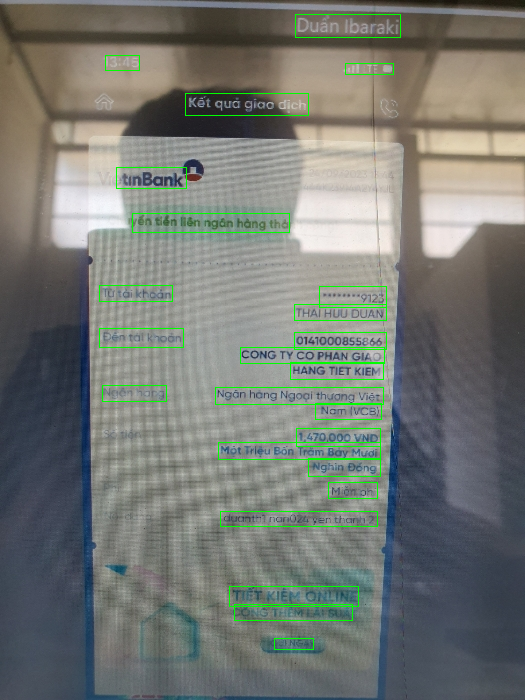

In [9]:
visualize(image_path, results)

In [10]:
def visualizeBoth(image, results, data):
    image = np.array(Image.open(image_path).convert('RGB'))

    for xyxy, textdet, label in results:
        xmin, ymin, xmax, ymax = xyxy
        bbox = np.array([[xmin, ymin], [xmax, ymin], [xmax, ymax], [xmin, ymax]], dtype=int)
        image = cv2.polylines(image, [bbox], True, (0, 255, 0), 1)
        image = cv2.putText(image, label, (xmin, ymin), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,0,255), 1)
    
    for ann in data['shapes']:
        xmin, ymin, xmax, ymax = list(chain.from_iterable(ann['points']))
        bbox = np.array([[xmin, ymin], [xmax, ymin], [xmax, ymax], [xmin, ymax]], dtype=int)
        image = cv2.polylines(image, [bbox], True, (255, 0, 0), 1)

    return Image.fromarray(image)

In [11]:
def visualizeIOU(image_path, results, data):
    image = np.array(Image.open(image_path).convert('RGB'))

    for xyxy in results:
        (xmin, ymin, xmax, ymax), label = xyxy
        bbox = np.array([[xmin, ymin], [xmax, ymin], [xmax, ymax], [xmin, ymax]], dtype=int)
        
        for ann in data['shapes']:
            xyxyB = list(chain.from_iterable(ann['points']))
            if calculate_iou_wrt_1(xyxy[0], xyxyB) > 0.5:
                image = cv2.polylines(image, [bbox], True, (0, 255, 0), 1)
                # image = cv2.putText(image, ann['label'].lower(), (xmin, ymin), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,0,255), 1)
                break
    
    for ann in data['shapes']:
        xmin, ymin, xmax, ymax = list(chain.from_iterable(ann['points']))
        bbox = np.array([[xmin, ymin], [xmax, ymin], [xmax, ymax], [xmin, ymax]], dtype=int)
        image = cv2.polylines(image, [bbox], True, (255, 0, 0), 1)

    cv2.imwrite(os.path.join('results', os.path.basename(image_path)), image)

    return Image.fromarray(image)

In [ ]:
samples = []
for i, (image_path, ann_path) in enumerate(zip(image_paths, ann_paths)):
    with open(ann_path, 'r') as file:
        data = json.load(file)
    results = get_text_ocr(image_path)
    new_results = []
    is_BIDV = False
    for xyxyA, textconf in results:
        isAnnotated = False
        for ann in data['shapes']:
            xyxyB = list(chain.from_iterable(ann['points']))
            if calculate_iou_wrt_1(xyxyA, xyxyB) > 0.7:
                isAnnotated = True
                xmin, ymin, xmax, ymax = xyxyA
                # if textconf[1] <= 0.5:
                #     continue
                new_results.append({
                    'label': ann['label'].lower(),
                    'transcription': textconf[0],
                    'points': np.array([[xmin, ymin], [xmax, ymin], [xmax, ymax], [xmin, ymax]], dtype=float).tolist()
                })
                break
        if not isAnnotated:
                xmin, ymin, xmax, ymax = xyxyA
                if 'BIDV' in textconf[0] or 'LPBank' in textconf[0]:
                    is_BIDV = True
                    break
                # if textconf[1] <= 0.5:
                #     continue
                new_results.append({
                    'label': 'ignore',
                    'transcription': textconf[0],
                    'points': np.array([[xmin, ymin], [xmax, ymin], [xmax, ymax], [xmin, ymax]], dtype=float).tolist()
                })
    if is_BIDV:
        continue
        
    if len(new_results) <= 10:
        print(os.path.basename(image_path), len(new_results))
        continue
    

    samples.append({
        'image': os.path.basename(image_path),
        'bboxes': new_results
    })
    

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
category = set()
for sample in samples:
    for bbox in sample['bboxes']:
        category.add(bbox['label'])

In [15]:
with open(save_dir / 'class_list.txt', 'w') as file:
    file.write('\n'.join(category))

In [16]:
train_samples, test_samples = train_test_split(samples, test_size=0.2)

In [17]:
with open(save_dir / 'train.txt', 'w') as file:
    for sample in train_samples:
        file.write(f'{sample["image"]}\t{json.dumps(sample["bboxes"], ensure_ascii=False)}\n')

In [18]:
with open(save_dir / 'test.txt', 'w') as file:
    for sample in test_samples:
        file.write(f'{sample["image"]}\t{json.dumps(sample["bboxes"], ensure_ascii=False)}\n')

In [19]:
# visualizeBoth(image_path, new_results, data)